In [9]:
import numpy as np
import cv2
import os
import re
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Dataset loaded
175 224 (224, 224) 75 175 75


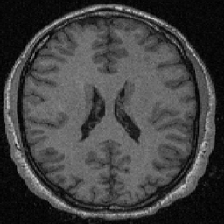

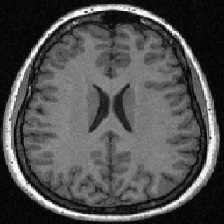

In [10]:
import numpy as np
import cv2
import os
import re
import tensorflow
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

# Load dataset and preprocess
healthy_path_train = '/content/gdrive/My Drive/Colab Notebooks/dataset_175/train/healthy'
schizophrenia_path_train = '/content/gdrive/My Drive/Colab Notebooks/dataset_175/train/schizophrenia'
healthy_path_test = '/content/gdrive/My Drive/Colab Notebooks/dataset_175/test/healthy'
schizophrenia_path_test = '/content/gdrive/My Drive/Colab Notebooks/dataset_175/test/schizophrenia'

def load_dataset(healthy_path_train, schizophrenia_path_train, healthy_path_test, schizophrenia_path_test):
    images_train = []
    images_test = []
    labels_train = []
    labels_test = []
    for img in os.listdir(healthy_path_train):
        img_path = os.path.join(healthy_path_train, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        #image = preprocess_input(image)
        images_train.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        labels_train.append(0)
    for img in os.listdir(schizophrenia_path_train):
        img_path = os.path.join(schizophrenia_path_train, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        #image = preprocess_input(image)
        images_train.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        labels_train.append(1)
    for img in os.listdir(healthy_path_test):
        img_path = os.path.join(healthy_path_test, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        #image = preprocess_input(image)
        images_test.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        labels_test.append(0)
    for img in os.listdir(schizophrenia_path_test):
        img_path = os.path.join(schizophrenia_path_test, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        #image = preprocess_input(image)
        images_test.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        labels_test.append(1)
    return np.array(images_train), np.array(images_test), np.array(labels_train), np.array(labels_test)

X_train_ml, X_test_ml, y_train_ml, y_test_ml = load_dataset(healthy_path_train, schizophrenia_path_train, healthy_path_test, schizophrenia_path_test)
print("Dataset loaded")
imgs_train, imgs_test, labels_train, labels_test = X_train_ml, X_test_ml, y_train_ml, y_test_ml
print(X_train_ml, X_test_ml, y_train_ml, y_test_ml)
print(len(X_train_ml),len(X_train_ml[0]), X_train_ml[0].shape,len(X_test_ml), len(y_train_ml), len(y_test_ml))
from google.colab.patches import cv2_imshow
cv2_imshow(imgs_train[5])
cv2_imshow(imgs_test[5])

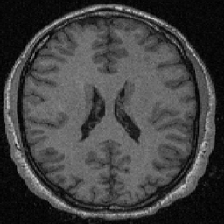

(175, 5665)


In [11]:
from skimage.feature import graycomatrix, graycoprops
imgs = imgs_train.astype(np.int32)
labels = labels_train.astype(np.int32)
cv2_imshow(imgs[5])

# ----------------- calculate greycomatrix() & greycoprops() for angle 0°, 30°, 45°, 60°, 90°, 120°, 135°, 150°, 180°----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[50], agls=[0, np.pi/6 , np.pi/4,  np.pi/3, np.pi/2, 2*np.pi/3 , 3*np.pi/4, 5*np.pi/6, np.pi], lvl=512, sym=True, norm=True):
#[0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(img,
                        distances=dists,
                        angles=agls,
                        levels=lvl,
                        symmetric=sym,
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in graycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label)
    #print(feature)
    return feature


# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
#properties = ['correlation']
glcm_all_agls = []

for img, label in zip(imgs, labels):
    glcm_all_agls.append(
            calc_glcm_all_agls(img,
                                label,
                                props=properties)
                            )

columns = []
angles = [0, np.pi/6 , np.pi/4,  np.pi/3, np.pi/2, 2*np.pi/3 , 3*np.pi/4, 5*np.pi/6, np.pi]
for name in properties :
    for ang in angles:
        columns.append(name + "_" + str(ang))

columns.append("label")
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls,
                      columns = columns)
glcm_df.shape


from skimage.feature import local_binary_pattern, hog
# Function to calculate HOG features for a single image
def calc_hog_feature(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
    # Calculate HOG features
    #hog_features, hog_image = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True)
    hog_features = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
    # Rescale histogram for better display
    #hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Return HOG features
    return hog_features

# Calculate HOG features for all images
hog_all = [calc_hog_feature(img) for img in imgs]

# Convert HOG features to DataFrame
hog_df = pd.DataFrame(hog_all, columns=[f'hog_{i}' for i in range(len(hog_all[0]))])

hog_df['label'] = labels
hog_df.shape


from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler
import pandas as pd
from skimage.feature import local_binary_pattern, hog
from skimage import exposure
import numpy as np
from scipy.stats import ttest_ind
# Function to calculate LBP features for a single image
def calc_lbp_feature(img, radius=1, n_points=200):
    lbp = local_binary_pattern(img, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    return hist

# Calculate LBP features for all images
lbp_all = [calc_lbp_feature(img) for img in imgs]

# Convert LBP features to DataFrame
lbp_df = pd.DataFrame(lbp_all, columns=[f'lbp_{i}' for i in range(len(lbp_all[0]))])
lbp_df['label'] = labels

# Concatenate LBP features with GLCM features
combined_df = pd.concat([hog_df.drop(columns=['label']),lbp_df.drop(columns=['label']),glcm_df], axis=1)
print(combined_df.shape)


X_train_df = combined_df.drop(columns=['label'])
y_train_df = combined_df['label']

# Scale the input data using StandardScaler
scaler_combined = StandardScaler()
X_scaled_train = scaler_combined.fit_transform(X_train_df.values)

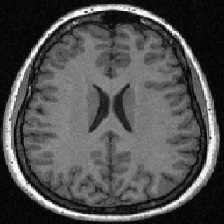

(75, 5665)


In [12]:
from skimage.feature import graycomatrix, graycoprops
imgs = imgs_test.astype(np.int32)
labels = labels_test.astype(np.int32)
cv2_imshow(imgs[5])

# ----------------- calculate greycomatrix() & greycoprops() for angle 0°, 30°, 45°, 60°, 90°, 120°, 135°, 150°, 180°----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[50], agls=[0, np.pi/6 , np.pi/4,  np.pi/3, np.pi/2, 2*np.pi/3 , 3*np.pi/4, 5*np.pi/6, np.pi], lvl=512, sym=True, norm=True):
#[0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(img,
                        distances=dists,
                        angles=agls,
                        levels=lvl,
                        symmetric=sym,
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in graycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label)
    #print(feature)
    return feature


# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
#properties = ['correlation']
glcm_all_agls = []

for img, label in zip(imgs, labels):
    glcm_all_agls.append(
            calc_glcm_all_agls(img,
                                label,
                                props=properties)
                            )

columns = []
angles = [0, np.pi/6 , np.pi/4,  np.pi/3, np.pi/2, 2*np.pi/3 , 3*np.pi/4, 5*np.pi/6, np.pi]
for name in properties :
    for ang in angles:
        columns.append(name + "_" + str(ang))

columns.append("label")
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls,
                      columns = columns)
glcm_df.shape

from skimage.feature import local_binary_pattern, hog
# Function to calculate HOG features for a single image
def calc_hog_feature(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
    # Calculate HOG features
    #hog_features, hog_image = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True)
    hog_features = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
    # Rescale histogram for better display
    #hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Return HOG features
    return hog_features

# Calculate HOG features for all images
hog_all = [calc_hog_feature(img) for img in imgs]

# Convert HOG features to DataFrame
hog_df = pd.DataFrame(hog_all, columns=[f'hog_{i}' for i in range(len(hog_all[0]))])

hog_df['label'] = labels
hog_df.shape


from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler
import pandas as pd
from skimage.feature import local_binary_pattern, hog
from skimage import exposure
import numpy as np
from scipy.stats import ttest_ind
# Function to calculate LBP features for a single image
def calc_lbp_feature(img, radius=1, n_points=200):
    lbp = local_binary_pattern(img, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    return hist

# Calculate LBP features for all images
lbp_all = [calc_lbp_feature(img) for img in imgs]

# Convert LBP features to DataFrame
lbp_df = pd.DataFrame(lbp_all, columns=[f'lbp_{i}' for i in range(len(lbp_all[0]))])
lbp_df['label'] = labels



# Concatenate LBP features with GLCM features
combined_df = pd.concat([hog_df.drop(columns=['label']),lbp_df.drop(columns=['label']),glcm_df], axis=1)
print(combined_df.shape)

X_test_df = combined_df.drop(columns=['label'])
y_test_df = combined_df['label']

# Scale the input data using StandardScaler
scaler_combined = StandardScaler()
X_scaled_test = scaler_combined.fit_transform(X_test_df.values)

In [25]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
#from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from xgboost import XGBClassifier
from sklearn.svm import SVC
num_selected_features = 175

#Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_ml = label_encoder.fit_transform(y_train_df)
y_test_ml = label_encoder.fit_transform(y_test_df)

print(X_scaled_train.shape, X_scaled_test.shape, y_train_ml.shape, y_test_ml.shape)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = X_scaled_train, X_scaled_test, y_train_ml, y_test_ml

pca = PCA(n_components=num_selected_features)
X_train_pca = pca.fit_transform(X_train_pca)
X_test_pca = pca.transform(X_test_pca)
print(X_train_pca.shape, X_test_pca.shape)
# Function to train and evaluate a classifier
def train_and_evaluate_classifier(classifier, X_train, y_train, X_test, y_test):
      model = classifier
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      y_prob = model.predict_proba(X_test)
      auc_roc = roc_auc_score(y_test, y_prob[:, 1])
      accuracy = accuracy_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
      #recall = recall_score(y_test, y_pred, average='weighted')
      f1 = f1_score(y_test, y_pred, average='weighted')
      conf_matrix = confusion_matrix(y_test, y_pred)
      specificity = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])
      recall = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])
      print(f"\nPerfomance Metrics:")
      print(f"Accuracy: {accuracy:.2f}")
      print(f"Precision: {precision:.2f}")
      print(f"Sensitivity (Recall): {recall:.2f}")
      print(f"Specificity: {specificity:.2f}")
      print(f"F1 Score: {f1:.2f}")
      print(f"AUC-ROC Score: {auc_roc:.2f}")
      print(f"Confusion matrix:\n", conf_matrix)

# Train and evaluate classifiers after PCA
# Logistic Regression
print("\nLogistic Regression:")
train_and_evaluate_classifier(LogisticRegression(max_iter=100), X_train_pca,  y_train_pca, X_test_pca, y_test_pca)

# Decision Tree
print("\nDecision Tree:")
train_and_evaluate_classifier(DecisionTreeClassifier(random_state=104), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

# SVC
print("\nSVC:")
train_and_evaluate_classifier(SVC(kernel='linear', probability=True,random_state=42), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

# Random Forest
print("\nRandom Forest:")
train_and_evaluate_classifier(RandomForestClassifier(n_estimators=1000, random_state=42), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

# Gradient Boosted Trees
print("\nGradient Boosted Trees:")
train_and_evaluate_classifier(GradientBoostingClassifier(n_estimators=100, random_state=59), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

# Extra Trees
#print("\nExtra Trees:")
#train_and_evaluate_classifier(ExtraTreesClassifier(n_estimators=100, random_state=42), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

# AdaBoost
print("\nAdaBoost:")
train_and_evaluate_classifier(AdaBoostClassifier(n_estimators=50, random_state=42), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

# HistGradientBoosting
print("\nHistGradientBoosting:")
train_and_evaluate_classifier(HistGradientBoostingClassifier(max_iter=100, random_state=42), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

# XGBoost Classifier
print("\nXGBoost:")
train_and_evaluate_classifier(XGBClassifier(n_estimators=100, random_state=42), X_train_pca, y_train_pca, X_test_pca, y_test_pca)


(175, 5664) (75, 5664) (175,) (75,)
(175, 175) (75, 175)

Logistic Regression:

Perfomance Metrics:
Accuracy: 0.84
Precision: 0.84
Sensitivity (Recall): 0.89
Specificity: 0.79
F1 Score: 0.84
AUC-ROC Score: 0.95
Confusion matrix:
 [[30  8]
 [ 4 33]]

Decision Tree:

Perfomance Metrics:
Accuracy: 0.64
Precision: 0.64
Sensitivity (Recall): 0.54
Specificity: 0.74
F1 Score: 0.64
AUC-ROC Score: 0.64
Confusion matrix:
 [[28 10]
 [17 20]]

SVC:

Perfomance Metrics:
Accuracy: 0.85
Precision: 0.86
Sensitivity (Recall): 0.89
Specificity: 0.82
F1 Score: 0.85
AUC-ROC Score: 0.94
Confusion matrix:
 [[31  7]
 [ 4 33]]

Random Forest:

Perfomance Metrics:
Accuracy: 0.76
Precision: 0.77
Sensitivity (Recall): 0.84
Specificity: 0.68
F1 Score: 0.76
AUC-ROC Score: 0.85
Confusion matrix:
 [[26 12]
 [ 6 31]]

Gradient Boosted Trees:

Perfomance Metrics:
Accuracy: 0.73
Precision: 0.73
Sensitivity (Recall): 0.70
Specificity: 0.76
F1 Score: 0.73
AUC-ROC Score: 0.79
Confusion matrix:
 [[29  9]
 [11 26]]

AdaBoos

In [21]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_ml = label_encoder.fit_transform(y_train_df)
y_test_ml = label_encoder.fit_transform(y_test_df)

print(X_scaled_train.shape, X_scaled_test.shape, y_train_ml.shape, y_test_ml.shape)

X_train_ml_rfe, X_test_ml_rfe, y_train_ml_rfe, y_test_ml_rfe = X_scaled_train, X_scaled_test, y_train_ml, y_test_ml

num_selected_features = 512

from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression(max_iter=100,penalty='l1', solver='liblinear')


rfe = RFE(estimator, n_features_to_select=num_selected_features,importance_getter='coef_')

# Fit the RFE model to the training data
X_train_rfe = rfe.fit_transform(X_train_ml_rfe, y_train_ml_rfe)
X_train_ml_rfe = X_train_ml_rfe[:,rfe.support_]

# Convert X_train_rfe to a DataFrame with column names
#X_train_ml_rfe = pd.DataFrame(X_train_rfe, columns=selected_feature_names)
print(X_train_ml_rfe.shape,y_train_ml_rfe.shape)

# Convert X_train_rfe to a DataFrame with column names
X_test_ml_rfe = X_test_ml_rfe[:, rfe.support_]
print(X_test_ml_rfe.shape,y_test_ml_rfe.shape)


(175, 5664) (75, 5664) (175,) (75,)
(175, 512) (175,)
(75, 512) (75,)



Metrics for LogisticRegression:
Accuracy: 0.85
Precision: 0.85
Sensitivity (Recall): 0.86
Specificity: 0.84
F1 Score: 0.85
AUC-ROC Score: 0.97
Confusion matrix:
 [[32  6]
 [ 5 32]]


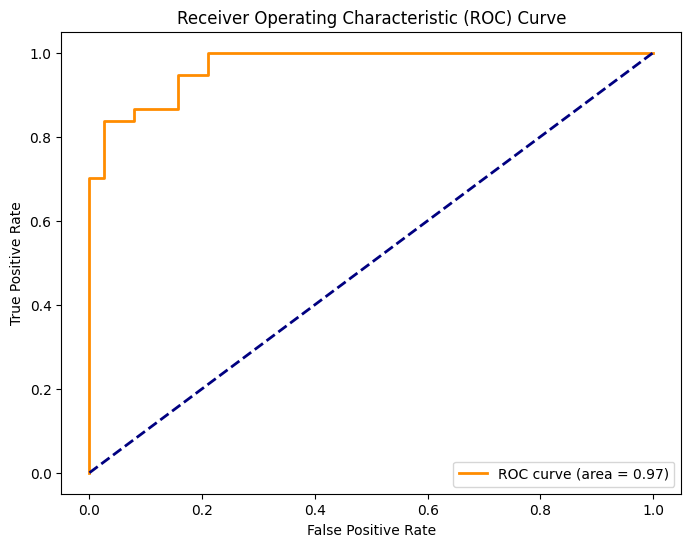

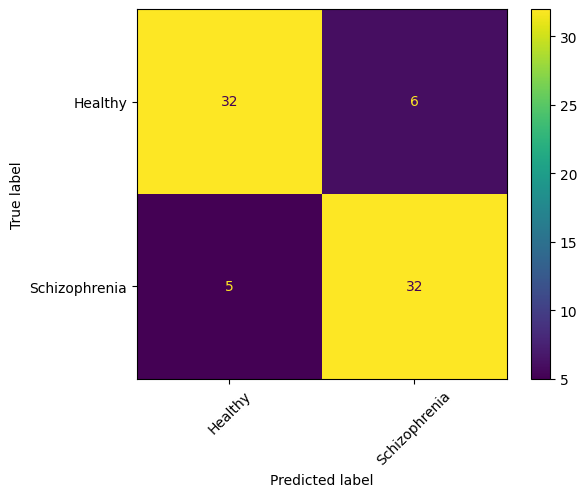

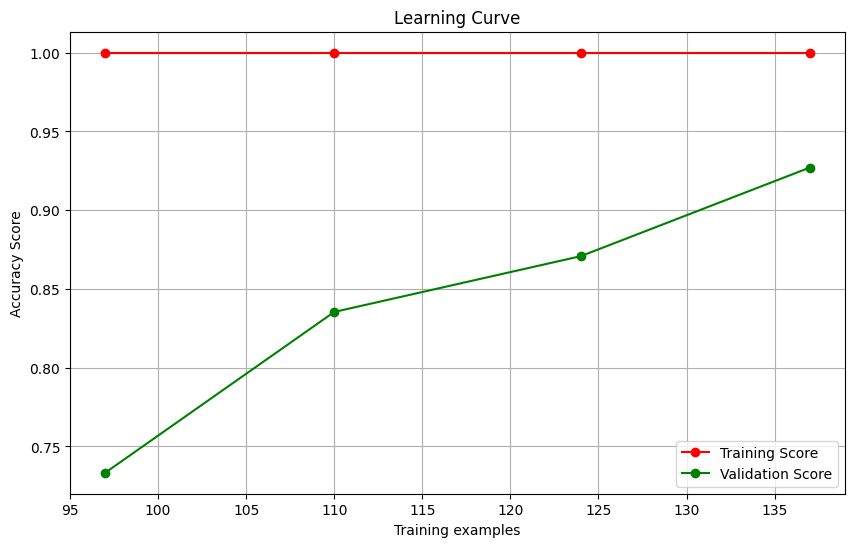


Metrics for DecisionTreeClassifier:
Accuracy: 0.61
Precision: 0.61
Sensitivity (Recall): 0.57
Specificity: 0.66
F1 Score: 0.61
AUC-ROC Score: 0.61
Confusion matrix:
 [[25 13]
 [16 21]]


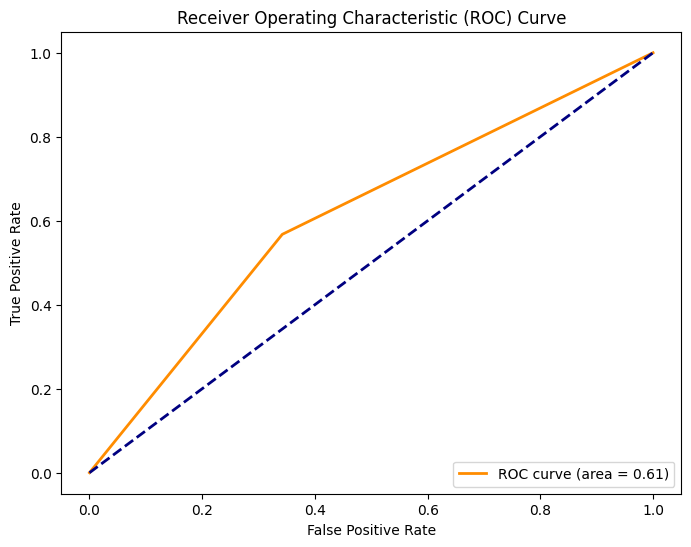

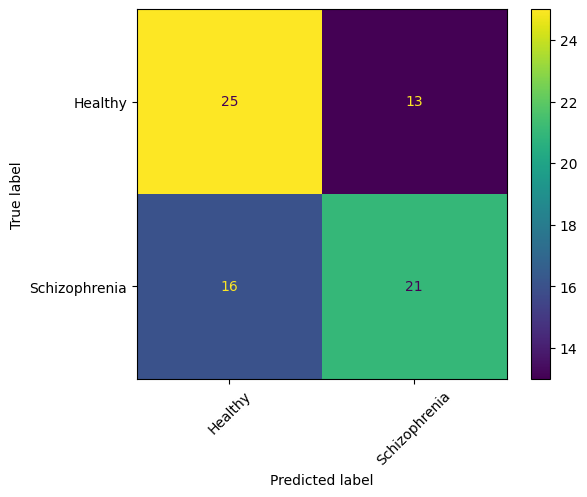

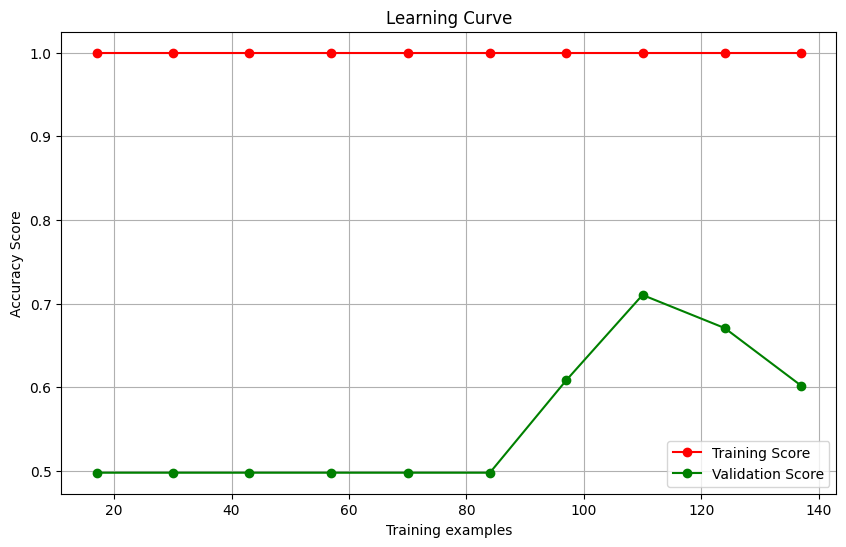


Metrics for SVC:
Accuracy: 0.88
Precision: 0.88
Sensitivity (Recall): 0.89
Specificity: 0.87
F1 Score: 0.88
AUC-ROC Score: 0.95
Confusion matrix:
 [[33  5]
 [ 4 33]]


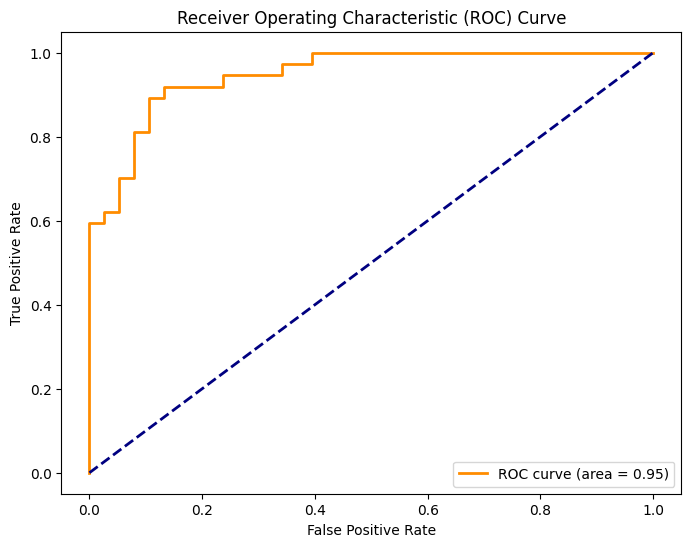

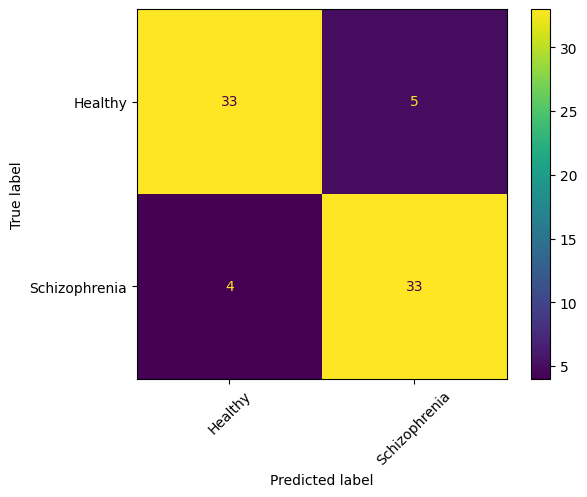

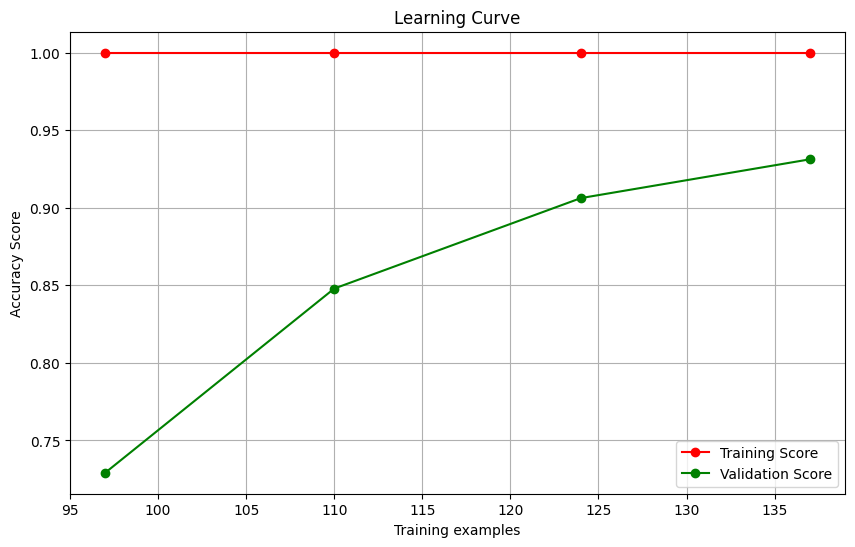


Metrics for HistGradientBoostingClassifier:
Accuracy: 0.89
Precision: 0.89
Sensitivity (Recall): 0.86
Specificity: 0.92
F1 Score: 0.89
AUC-ROC Score: 0.95
Confusion matrix:
 [[35  3]
 [ 5 32]]


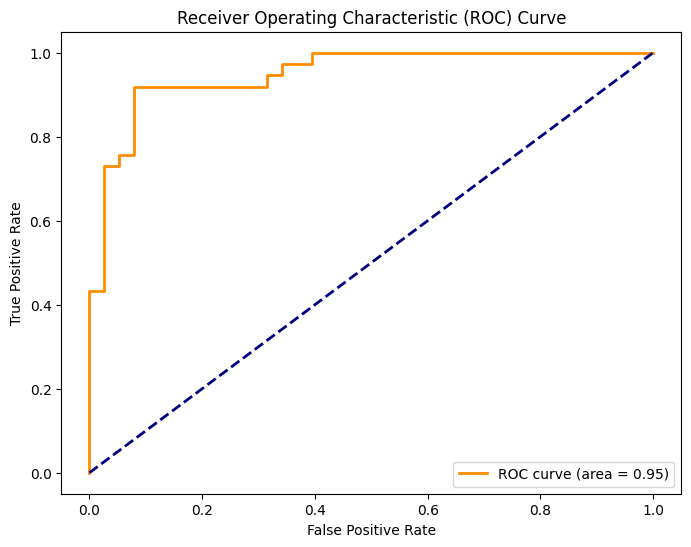

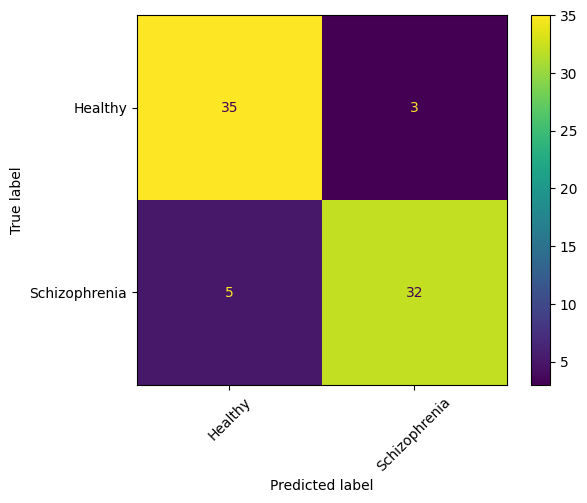

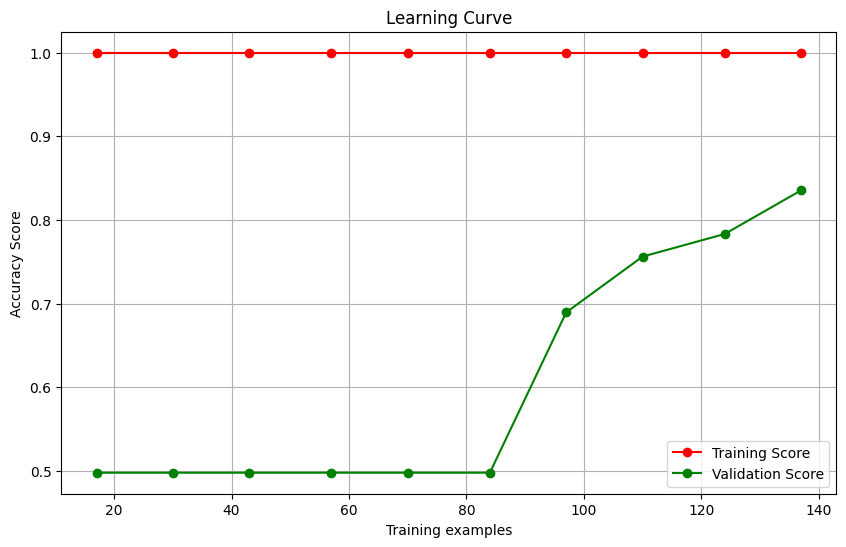


Metrics for RandomForestClassifier:
Accuracy: 0.87
Precision: 0.87
Sensitivity (Recall): 0.89
Specificity: 0.84
F1 Score: 0.87
AUC-ROC Score: 0.94
Confusion matrix:
 [[32  6]
 [ 4 33]]


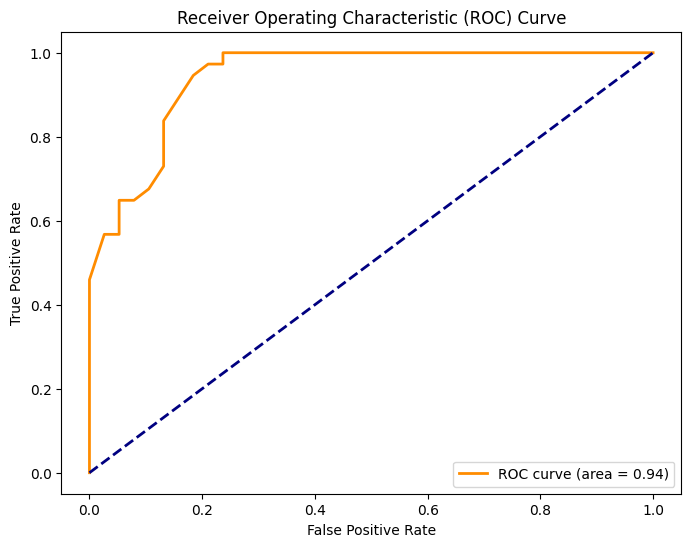

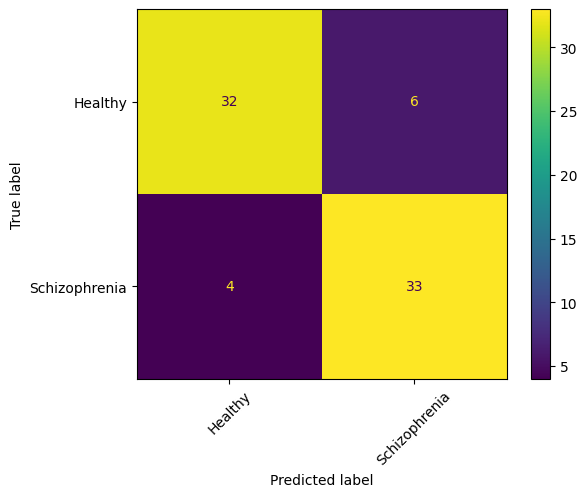

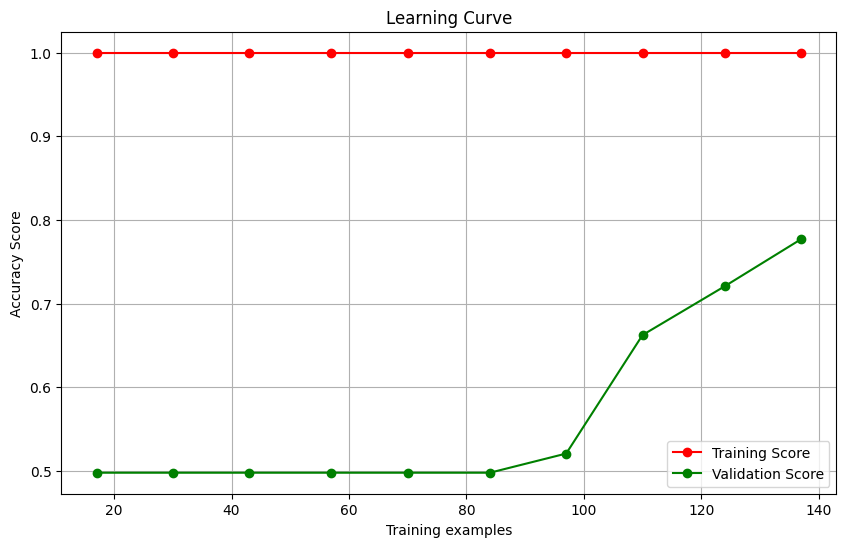


Metrics for GradientBoostingClassifier:
Accuracy: 0.79
Precision: 0.79
Sensitivity (Recall): 0.76
Specificity: 0.82
F1 Score: 0.79
AUC-ROC Score: 0.91
Confusion matrix:
 [[31  7]
 [ 9 28]]


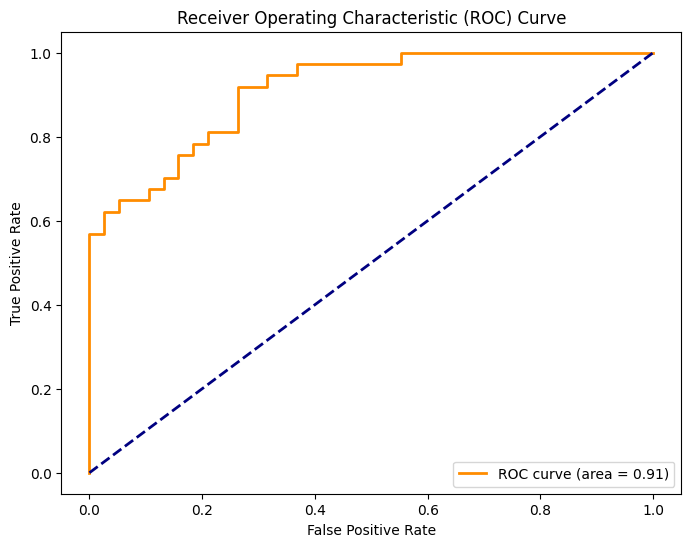

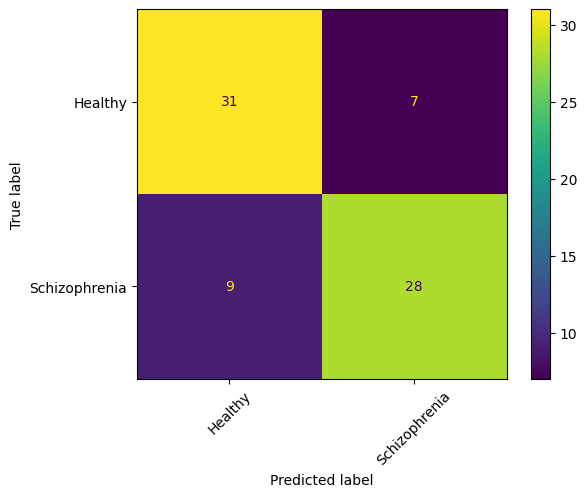

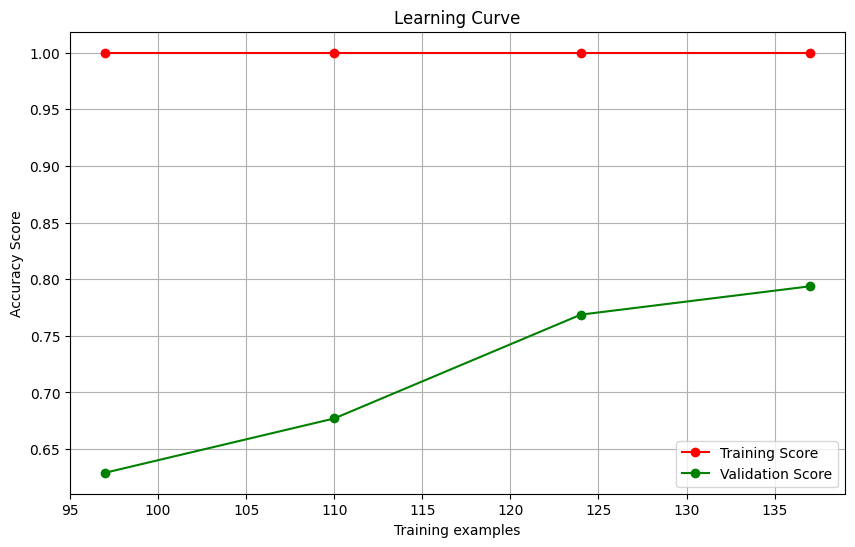


Metrics for AdaBoostClassifier:
Accuracy: 0.87
Precision: 0.87
Sensitivity (Recall): 0.86
Specificity: 0.87
F1 Score: 0.87
AUC-ROC Score: 0.94
Confusion matrix:
 [[33  5]
 [ 5 32]]


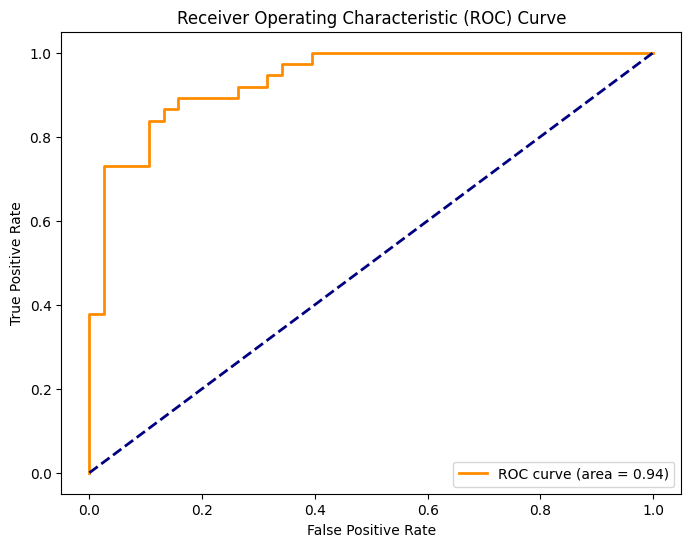

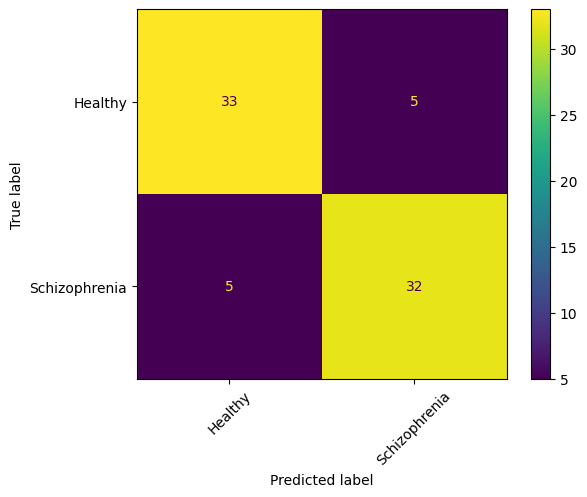

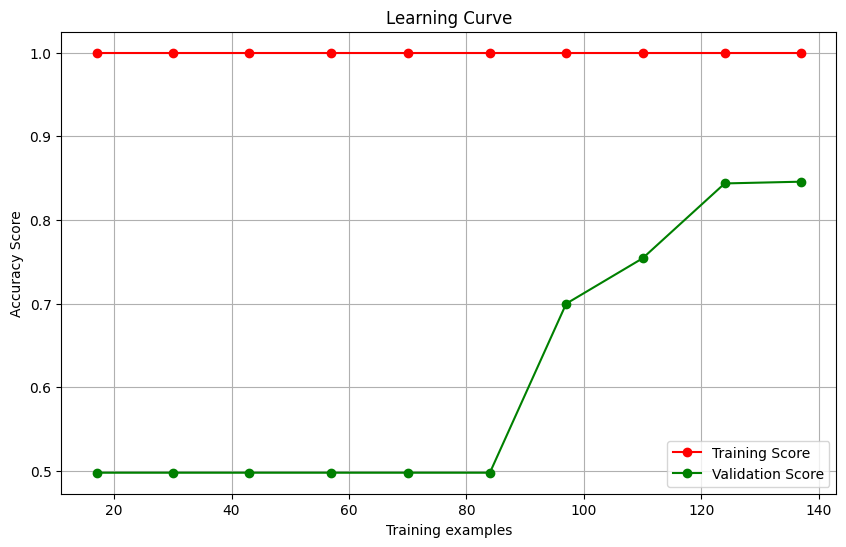


Metrics for XGBClassifier:
Accuracy: 0.87
Precision: 0.87
Sensitivity (Recall): 0.81
Specificity: 0.92
F1 Score: 0.87
AUC-ROC Score: 0.92
Confusion matrix:
 [[35  3]
 [ 7 30]]


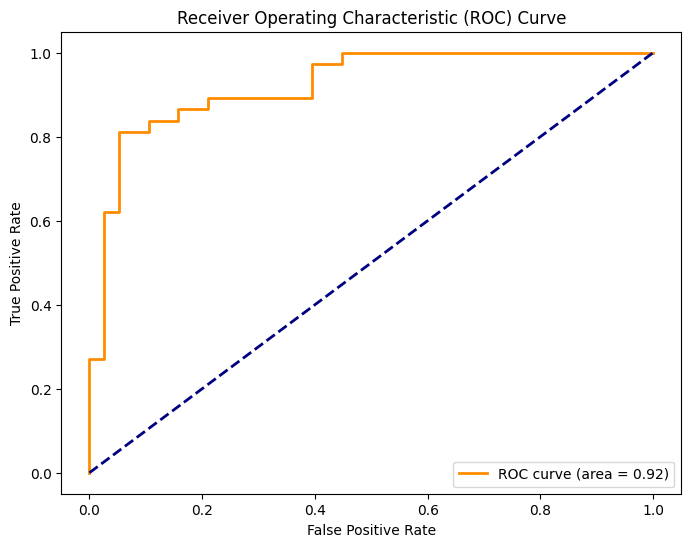

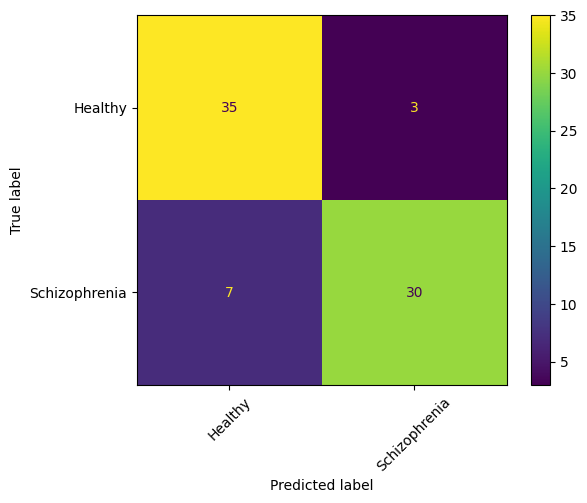

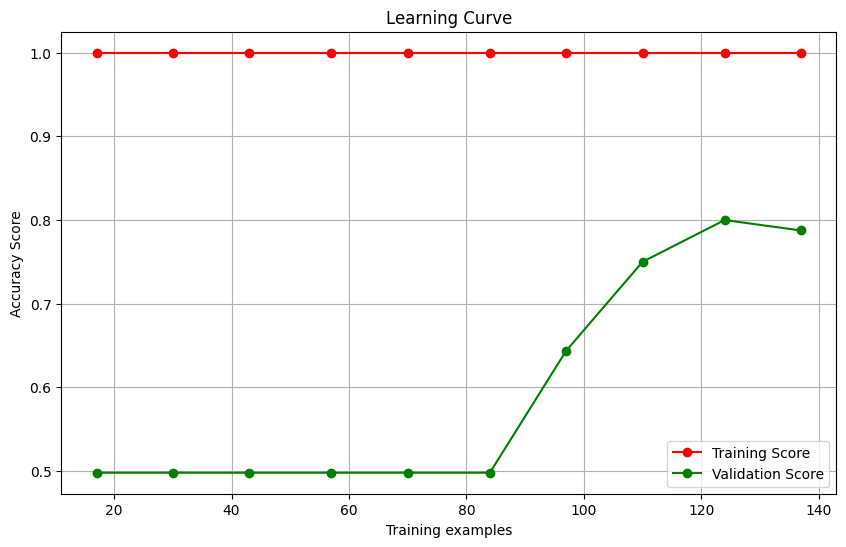

In [24]:


def train_evaluate_rfe(classifier, X_train_ml_rfe, y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features, random_state=42, plot_roc=False, plot_f1=False, plot_corr=False, plot_learning_curve = False):

      # Train the model using the selected features
      model = classifier
      model.fit(X_train_ml_rfe, y_train_ml_rfe)

      y_pred = model.predict(X_test_ml_rfe)

      # Predict probabilities for each class on the test set
      y_prob = model.predict_proba(X_test_ml_rfe)
       # Calculate AUC-ROC score for the positive class
      fpr, tpr, thresholds = roc_curve(y_test_ml_rfe, y_prob[:, 1])
      auc_roc = auc(fpr, tpr)
      # Calculate AUC-ROC score for the positive class
      auc_roc_score = roc_auc_score(y_test_ml_rfe, y_prob[:, 1])

      # Print metrics
      accuracy = accuracy_score(y_test_ml_rfe, y_pred)
      precision = precision_score(y_test_ml_rfe, y_pred, average='weighted', zero_division=1)
      #recall = recall_score(y_test, y_pred, average='weighted')
      f1 = f1_score(y_test_ml_rfe, y_pred, average='weighted')
      conf_matrix = confusion_matrix(y_test_ml_rfe, y_pred)
      # specificity = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

      # Handle the case when there are no true negatives
      if conf_matrix[0, 0] + conf_matrix[0, 1] != 0:
        specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
      else:
        specificity = 0.0
      recall = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])

      print(f"\nMetrics for {type(classifier).__name__}:")
      print(f"Accuracy: {accuracy:.2f}")
      print(f"Precision: {precision:.2f}")
      print(f"Sensitivity (Recall): {recall:.2f}")
      print(f"Specificity: {specificity:.2f}")
      print(f"F1 Score: {f1:.2f}")
      print(f"AUC-ROC Score: {auc_roc_score:.2f}")
      print(f"Confusion matrix:\n", conf_matrix)

      if plot_roc:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_roc))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

      # Plot F1 score over different thresholds
      if plot_f1:
        labels=  ["Healthy", "Schizophrenia"]
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
        disp.plot(xticks_rotation=45)

      # Print correlation matrix
      if plot_corr:
        corr_matrix = X_train_ml_rfe.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Selected Features')
        plt.show()

      if plot_learning_curve:
        train_sizes, train_scores, validation_scores = learning_curve(classifier, X_train_ml_rfe, y_train_ml_rfe, cv=80, scoring='accuracy', train_sizes=np.linspace(0.1, 0.8, 10))
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training Score")
        plt.plot(train_sizes, np.mean(validation_scores, axis=1), 'o-', color="g", label="Validation Score")

        plt.xlabel("Training examples")
        plt.ylabel("Accuracy Score")
        plt.title("Learning Curve")
        plt.legend(loc="best")
        plt.grid(True)
        plt.show()




#Logistic Regression
classifier = LogisticRegression(max_iter=100,penalty='l1', solver='liblinear')
train_evaluate_rfe(classifier, X_train_ml_rfe,  y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features, plot_roc=True, plot_f1=True, plot_learning_curve=True)

# Decision Tree
classifier = DecisionTreeClassifier(random_state=104)
train_evaluate_rfe(classifier, X_train_ml_rfe,  y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features,random_state=104, plot_roc=True, plot_f1=True, plot_learning_curve=True)

# Define an SVM classifier
classifier = SVC(kernel= 'linear', C= 0.1, gamma= 0.1, degree= 2, probability=True, random_state=42) #87
#classifier = SVC(kernel= 'rbf', C= 0.1, gamma= 'auto', degree= 2, probability=True, random_state=42) 89
train_evaluate_rfe(classifier, X_train_ml_rfe,  y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features, random_state=42, plot_roc=True, plot_f1=True, plot_corr=False, plot_learning_curve=True)

# Define an SVM classifier
#classifier = SVC(kernel= 'linear', C= 0.1, gamma= 0.1, degree= 2, probability=True, random_state=42) #87
#classifier = SVC(kernel= 'rbf', C= 0.1, gamma= 'auto', degree= 2, probability=True, random_state=42)
#train_evaluate_rfe(classifier, X_train_ml_rfe,  y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features, random_state=42, plot_roc=True, plot_f1=True, plot_corr=False, plot_learning_curve=True)

# Extra Trees Classifier
#classifier = ExtraTreesClassifier(n_estimators=100, random_state=20)
#train_evaluate_rfe(classifier, X_train_ml_rfe,  y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features,random_state=20,plot_roc=True, plot_f1=True, plot_learning_curve=True)

# HistGradientBoosting Classifier
classifier = HistGradientBoostingClassifier(max_iter=100, random_state=42)
train_evaluate_rfe(classifier , X_train_ml_rfe,  y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features ,plot_roc=True, plot_f1=True, plot_learning_curve=True)

# Random Forest
classifier = RandomForestClassifier(n_estimators=100, random_state=29)
train_evaluate_rfe(classifier, X_train_ml_rfe,  y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features,random_state=29,plot_roc=True, plot_f1=True, plot_learning_curve=True)

# Gradient Boosted Trees
classifier = GradientBoostingClassifier(n_estimators=100, random_state=59)
train_evaluate_rfe(classifier, X_train_ml_rfe,  y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features,random_state=59,plot_roc=True, plot_f1=True, plot_learning_curve=True)

# AdaBoost Classifier
classifier = AdaBoostClassifier(n_estimators=100, random_state=42)
train_evaluate_rfe(classifier, X_train_ml_rfe,  y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features,plot_roc=True, plot_f1=True, plot_learning_curve=True)

# XGBoost Classifier
classifier = XGBClassifier(n_estimators=100, random_state=42)
train_evaluate_rfe(classifier, X_train_ml_rfe,  y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features, random_state=42, plot_roc=True, plot_f1=True, plot_learning_curve=True)
